<a href="https://colab.research.google.com/github/LeoMcBills/ML_malariaDiagnosis/blob/main/Tensorflow/basics1/malariaPredictionmbubesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input, Dropout, RandomFlip
from keras.src.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import albumentations as A
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalseNegatives, FalsePositives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=["train"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteVNBPNQ/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [4]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_testdataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_testdataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = val_testdataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [5]:
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [6]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


# Data visualizaion

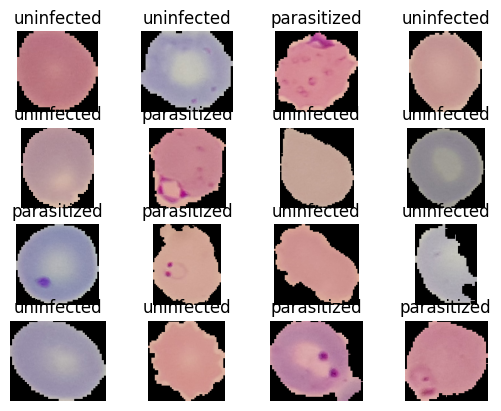

In [7]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# IMAGE PROCESSING

In [8]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)

In [9]:
original_image, label = next(iter(train_dataset))

In [10]:
augmented_image = tf.image.flip_left_right(original_image)

In [11]:
augmented_image2 = tf.image.random_flip_up_down(original_image)

In [12]:
augmented_image3 = tf.image.rot90(original_image)

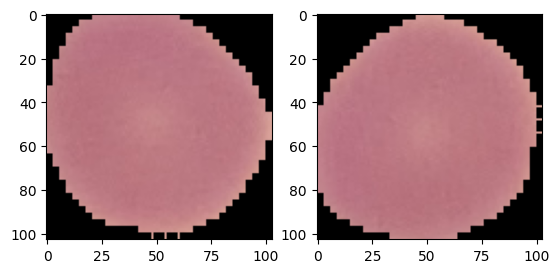

In [13]:
visualize(original_image, augmented_image3)

# Albumentation

In [14]:
# IM_SIZE = 224
# transforms = A.Compose([
#     A.Resize(IM_SIZE, IM_SIZE),
#     A.OneOf([
#         A.HorizontalFlip(),
#         A.VerticalFlip(),], p = 0.3),
#     A.RandomRotate90(),
#     # A.RandomGridShuffle(),
# ])

In [15]:
# def aug_albument(image):
#   data = {"image":image}
#   image = transforms(**data)
#   image = image["image"]
#   image = tf.cast(image/255., tf.float32)
#   return image

In [16]:
# def process_data(image, label):
#   aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
#   return aug_img, label

# Data Processing

In [17]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [18]:
# tf.image augment
def augment(image, label):
  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image)
  # image = tf.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)
  return image, label

In [19]:
# tf.keras.layer augment
# augment_layers = tf.keras.Sequential([

# ])

In [20]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(augment)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
    )

In [21]:
# train_dataset = (
#     train_dataset
#     .shuffle(buffer_size=8, reshuffle_each_iteration=True)
#     .map(process_data)
#     .batch(32)
#     .prefetch(tf.data.AUTOTUNE)
#     )

In [22]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
# im, _ = next(iter(train_dataset))
# plt.imshow(im[0])

In [24]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    .map(resize_rescale)
    .batch(32).prefetch(tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    )

In [25]:
train_dataset = train_dataset.map(augment)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [26]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

# Model creation

In [27]:
model = tf.keras.Sequential([
                            InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                            Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Flatten(),

                            Dense(1000, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(100, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(1, activation="sigmoid"),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Functional API

In [28]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64    

In [29]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor = Model(func_input, output, name="feature_extractor")
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)

In [30]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = feature_extractor(func_input)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 1000)              46657000  
                                                                 
 batch_normalization_10 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 100)               100100

# Model Subclassing

In [31]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

# Metrics

In [32]:
metrics = [BinaryAccuracy(name="accuracy"), TruePositives(name='tp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           FalsePositives(name='fp'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

# CallBacks

In [33]:
# Callback
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [34]:
# CSVLogger
csvlogger = CSVLogger(
    'logs.csv', separator=',', append=False
)

In [35]:
# EarlyStopping
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [36]:
# Learning rate schedular
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrSchedular = LearningRateScheduler(scheduler, verbose=1)

In [37]:
# Model checkpointing
checkPoint = ModelCheckpoint(
    'checkpoint/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq=3,
)

In [38]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=metrics)

# Training

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1,
                    callbacks=[csvlogger, earlystopping, lrSchedular, checkPoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
  2/689 [..............................] - ETA: 32:34 - loss: 3.0668 - accuracy: 0.5000 - tp: 19.0000 - tn: 13.0000 - fn: 14.0000 - fp: 18.0000 - precision: 0.5135 - recall: 0.5758 - auc: 0.4844

  5/689 [..............................] - ETA: 33:30 - loss: 3.0592 - accuracy: 0.5375 - tp: 42.0000 - tn: 44.0000 - fn: 42.0000 - fp: 32.0000 - precision: 0.5676 - recall: 0.5000 - auc: 0.5257

  8/689 [..............................] - ETA: 31:57 - loss: 2.3103 - accuracy: 0.5352 - tp: 71.0000 - tn: 66.0000 - fn: 64.0000 - fp: 55.0000 - precision: 0.5635 - recall: 0.5259 - auc: 0.5395

 11/689 [..............................] - ETA: 31:52 - loss: 1.9046 - accuracy: 0.5199 - tp: 87.0000 - tn: 96.0000 - fn: 95.0000 - fp: 74.0000 - precision: 0.5404 - recall: 0.4780 - auc: 0.5318

 14/689 [..............................] - ETA: 31:41 - loss: 1.6418 - accuracy: 0.5223 - tp: 125.0000 - tn: 109.0000 - fn: 115.0000 - fp: 99.0000 - precision: 0.5580 - recall: 0.5208 - auc: 0.5374

 17/689 [..............................] - ETA: 31:35 - loss: 1.4859 - accuracy: 0.4908 - tp: 153.0000 - tn: 114.0000 - fn: 130.0000 - fp: 147.0000 - precision: 0.5100 - recall: 0.5406 - auc: 0.5225

 20/689 [..............................] - ETA: 31:34 - loss: 1.3714 - accuracy: 0.4812 - tp: 189.0000 - tn: 119.0000 - fn: 138.0000 - fp: 194.0000 - precision: 0.4935 - recall: 0.5780 - auc: 0.5121

 23/689 [>.............................] - ETA: 31:23 - loss: 1.2812 - accuracy: 0.4864 - tp: 219.0000 - tn: 139.0000 - fn: 158.0000 - fp: 220.0000 - precision: 0.4989 - recall: 0.5809 - auc: 0.5138

 26/689 [>.............................] - ETA: 31:20 - loss: 1.2147 - accuracy: 0.4964 - tp: 230.0000 - tn: 183.0000 - fn: 190.0000 - fp: 229.0000 - precision: 0.5011 - recall: 0.5476 - auc: 0.5209

 29/689 [>.............................] - ETA: 30:43 - loss: 1.1649 - accuracy: 0.4968 - tp: 244.0000 - tn: 217.0000 - fn: 225.0000 - fp: 242.0000 - precision: 0.5021 - recall: 0.5203 - auc: 0.5197

 32/689 [>.............................] - ETA: 29:22 - loss: 1.1213 - accuracy: 0.4990 - tp: 259.0000 - tn: 252.0000 - fn: 266.0000 - fp: 247.0000 - precision: 0.5119 - recall: 0.4933 - auc: 0.5208

 35/689 [>.............................] - ETA: 28:43 - loss: 1.0839 - accuracy: 0.4982 - tp: 279.0000 - tn: 279.0000 - fn: 295.0000 - fp: 267.0000 - precision: 0.5110 - recall: 0.4861 - auc: 0.5210

 38/689 [>.............................] - ETA: 27:39 - loss: 1.0517 - accuracy: 0.5074 - tp: 319.0000 - tn: 298.0000 - fn: 315.0000 - fp: 284.0000 - precision: 0.5290 - recall: 0.5032 - auc: 0.5240

 41/689 [>.............................] - ETA: 26:56 - loss: 1.0262 - accuracy: 0.5038 - tp: 352.0000 - tn: 309.0000 - fn: 336.0000 - fp: 315.0000 - precision: 0.5277 - recall: 0.5116 - auc: 0.5206

 44/689 [>.............................] - ETA: 26:21 - loss: 1.0041 - accuracy: 0.5057 - tp: 393.0000 - tn: 319.0000 - fn: 345.0000 - fp: 351.0000 - precision: 0.5282 - recall: 0.5325 - auc: 0.5192

 47/689 [=>............................] - ETA: 25:36 - loss: 0.9817 - accuracy: 0.5153 - tp: 431.0000 - tn: 344.0000 - fn: 360.0000 - fp: 369.0000 - precision: 0.5387 - recall: 0.5449 - auc: 0.5290

 50/689 [=>............................] - ETA: 25:16 - loss: 0.9651 - accuracy: 0.5181 - tp: 452.0000 - tn: 377.0000 - fn: 386.0000 - fp: 385.0000 - precision: 0.5400 - recall: 0.5394 - auc: 0.5316

 53/689 [=>............................] - ETA: 24:43 - loss: 0.9486 - accuracy: 0.5224 - tp: 479.0000 - tn: 407.0000 - fn: 409.0000 - fp: 401.0000 - precision: 0.5443 - recall: 0.5394 - auc: 0.5363

 56/689 [=>............................] - ETA: 24:08 - loss: 0.9345 - accuracy: 0.5246 - tp: 506.0000 - tn: 434.0000 - fn: 433.0000 - fp: 419.0000 - precision: 0.5470 - recall: 0.5389 - auc: 0.5388

 59/689 [=>............................] - ETA: 23:58 - loss: 0.9229 - accuracy: 0.5228 - tp: 536.0000 - tn: 451.0000 - fn: 442.0000 - fp: 459.0000 - precision: 0.5387 - recall: 0.5481 - auc: 0.5376

 62/689 [=>............................] - ETA: 23:28 - loss: 0.9125 - accuracy: 0.5237 - tp: 573.0000 - tn: 466.0000 - fn: 453.0000 - fp: 492.0000 - precision: 0.5380 - recall: 0.5585 - auc: 0.5360

 65/689 [=>............................] - ETA: 23:01 - loss: 0.9018 - accuracy: 0.5255 - tp: 599.0000 - tn: 494.0000 - fn: 480.0000 - fp: 507.0000 - precision: 0.5416 - recall: 0.5551 - auc: 0.5379

 68/689 [=>............................] - ETA: 22:53 - loss: 0.8903 - accuracy: 0.5322 - tp: 629.0000 - tn: 529.0000 - fn: 500.0000 - fp: 518.0000 - precision: 0.5484 - recall: 0.5571 - auc: 0.5467

 71/689 [==>...........................] - ETA: 22:29 - loss: 0.8819 - accuracy: 0.5343 - tp: 660.0000 - tn: 554.0000 - fn: 524.0000 - fp: 534.0000 - precision: 0.5528 - recall: 0.5574 - auc: 0.5494

 74/689 [==>...........................] - ETA: 22:10 - loss: 0.8732 - accuracy: 0.5380 - tp: 689.0000 - tn: 585.0000 - fn: 541.0000 - fp: 553.0000 - precision: 0.5548 - recall: 0.5602 - auc: 0.5545

 77/689 [==>...........................] - ETA: 22:00 - loss: 0.8641 - accuracy: 0.5434 - tp: 727.0000 - tn: 612.0000 - fn: 554.0000 - fp: 571.0000 - precision: 0.5601 - recall: 0.5675 - auc: 0.5605

 79/689 [==>...........................] - ETA: 21:46 - loss: 0.8599 - accuracy: 0.5443 - tp: 753.0000 - tn: 623.0000 - fn: 562.0000 - fp: 590.0000 - precision: 0.5607 - recall: 0.5726 - auc: 0.5610

# Visualizing output

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
model.evaluate(test_dataset)

In [ ]:
def parasite_or_not(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')